<a href="https://colab.research.google.com/github/iannellif/churn/blob/main/eth_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Load Data

In [2]:
import requests
import tarfile
import io
import pandas as pd
import os

url = "https://raw.githubusercontent.com/iannellif/churn/main/eth_df_churn.tar.gz"

# Download the tar.gz file
response = requests.get(url)
tar_file = tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz")

# Extract the CSV file
tar_file.extractall("/content/churn_data")
tar_file.close()

# List extracted files
extracted_files = os.listdir("/content/churn_data")
print("Extracted files:", extracted_files)

df = pd.read_csv("/content/churn_data/eth_df_churn.csv")

print("\nData loaded successfully. Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Extracted files: ['eth_df_churn.csv']

Data loaded successfully. Shape: (100000, 40)

First few rows:


,-3Q,-4Q,0Q,1Q,NATIONALITY,CUST_IS_RESIDENT,CUST_DOMICILE_CODE,LANGUAGE_DESC,GENDER,MARITAL_STATUS,OCCUPATION,CUST_NO_CHILDREN,ACCT_AGE,CUST_MONTHLY_INCOME,YEARS_SINCE_LAST_APPL,CUST_PARTNER_CIF,CUSTOMER_LOYALTY,INCOME_GROUP,ACCOUNT_AGE_GROUP,CUSTOMER_AGE_GROUP,LIMIT,BALANCE,MOB,CARDS,TOTAL_NUM_TRANSACTIONS,AVG_CHF,TOTAL_AMOUNT,MAX_AMOUNT,MIN_AMOUNT,PERCENTILE_25,PERCENTILE_50,PERCENTILE_75,ENTROPY,RECENCY,MEAN_TRANSACTIONS,CUMULANT2,CUMULANT3,CUMULANT4,SKEWNESS,KURTOSIS
0,0.00,1283.10,1100.62,2900.38,Other,Resident,CH,German,MALE,Married,Salaried Employee,Many,12.0,6503.17,12.0,SCH,18.0,Medium,Long-term,Adult,6000.0,-19.79,135,1,1.0,1100.62,1100.62,1100.62,1100.62,1100.62,1100.62,1100.62,0.00,6.0,0.08,0.00,0.00,0.000000e+00,0.00,-3.00
1,979.40,1809.10,737.00,633.60,Switzerland,Resident,CH,French,MALE,Married,Salaried Employee,Many,12.0,5165.00,12.0,PCH,12.0,Medium,Long-term,Adult,16000.0,12909.91,135,1,2.0,368.50,737.00,437.00,300.00,334.25,368.50,402.75,1.00,8.0,0.15,4692.25,0.00,2.201721e+07,0.00,-2.75
2,358.85,1716.50,404.11,467.98,Switzerland,Resident,CH,Italian,FEMALE,Divorced,Salaried Employee,Many,12.0,3031.00,12.0,PCH,12.0,Medium,Long-term,Adult,5000.0,3787.31,135,1,15.0,26.94,404.11,77.00,-2.81,6.41,20.65,27.90,3.70,8.0,1.15,688.79,18046.47,1.258844e+06,0.90,-0.69
3,2046.20,1976.74,1598.35,3479.06,Portugal,Resident,CH,French,MALE,Single,Salaried Employee,Many,12.0,3820.00,13.0,PCH,12.0,Medium,Long-term,Adult,3000.0,1848.06,135,1,46.0,34.75,1598.35,401.70,0.40,4.98,9.18,20.69,5.43,2.0,3.54,6685.56,2147714.17,7.897477e+08,3.80,13.91
4,3112.37,650.76,648.07,1753.90,Other,Resident,CH,German,FEMALE,Married,Salaried Employee,One,12.0,6176.75,12.0,SCH,14.0,Medium,Long-term,Adult,8000.0,4629.63,135,1,48.0,13.93,668.82,980.00,-580.00,1.20,8.90,27.26,4.95,6.0,3.69,36263.97,12660279.88,2.234689e+10,1.78,13.29


In [ ]:
# Define the disengagement threshold for the label
decrease_percent = 0.25

# Function to set negative values to 0
def set_negative_to_zero(value):
    return max(value, 0)

# Apply the function to set negative values to 0 in '0Q' and '1Q'
df['0Q'] = df['0Q'].apply(set_negative_to_zero)
df['1Q'] = df['1Q'].apply(set_negative_to_zero)

# Create the flag column based on the decrease percentage
def calculate_flag(current, previous):
    if previous == 0:
        return 0  # Avoid division by zero
    # percentage change between the current value and the previous value
    change = (current - previous) / previous
    return 1 if change < -decrease_percent else 0

df['0Q_FLAG'] = df.apply(lambda row: calculate_flag(row['0Q'], row['-4Q']), axis=1)
df['1Q_FLAG'] = df.apply(lambda row: calculate_flag(row['1Q'], row['-3Q']), axis=1)


def categorize(row):
    if row['0Q_FLAG'] == 0:
        return 'NEGATIVE'
    elif row['0Q_FLAG'] == 1 and row['1Q_FLAG'] == 1:
        return 'TRUE POSITIVE'
    elif row['0Q_FLAG'] == 1 and row['1Q_FLAG'] == 0:
        return 'FALSE POSITIVE'
    else:
        return 'UNKNOWN'

df['CAT'] = df.apply(categorize, axis=1)

# Remove future flags and spending
del df['1Q']
del df['0Q_FLAG']
del df['1Q_FLAG']

df

KeyError: '1Q'

In [ ]:
df['CAT'].value_counts()

,count
CAT,
NEGATIVE,54406
TRUE POSITIVE,28824
FALSE POSITIVE,16770


In [ ]:
df.describe()

,-3Q,-4Q,0Q,ACCT_AGE,CUST_MONTHLY_INCOME,YEARS_SINCE_LAST_APPL,CUSTOMER_LOYALTY,LIMIT,BALANCE,MOB,CARDS,TOTAL_NUM_TRANSACTIONS,AVG_CHF,TOTAL_AMOUNT,MAX_AMOUNT,MIN_AMOUNT,PERCENTILE_25,PERCENTILE_50,PERCENTILE_75,ENTROPY,RECENCY,MEAN_TRANSACTIONS,CUMULANT2,CUMULANT3,CUMULANT4,SKEWNESS,KURTOSIS
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,95084.000000,95084.000000,95084.000000,95084.000000,95084.000000,95084.000000,95084.000000,95084.000000,95084.000000,95084.000000,95084.000000,9.508400e+04,9.508400e+04,9.508400e+04,95084.000000,95084.000000
mean,4317.025621,4517.934485,3507.040066,14.167165,4.992629e+03,14.128522,14.817955,6827.058120,1279.322944,158.690920,1.383740,59.416747,90.538418,3737.726213,769.699142,-50.616922,24.627436,47.180627,97.881537,4.856562,5.866087,4.570512,5.842665e+04,2.152742e+08,5.104391e+12,2.716444,14.392576
std,3753.298037,3898.795144,3781.240026,2.758160,1.701090e+04,3.625353,2.738087,3073.858555,2221.976009,31.955343,0.531908,60.657347,159.994274,3832.747241,938.856733,254.428031,121.259819,138.650815,191.076049,1.692800,12.240114,4.665964,1.160800e+06,2.901174e+10,1.305129e+15,2.320240,24.334057
min,-9108.500000,-5712.520000,0.000000,2.000000,0.000000e+00,0.000000,2.000000,400.000000,-40276.460000,14.000000,0.000000,1.000000,-2618.740000,-7015.490000,-2618.740000,-9000.000000,-2618.740000,-2618.740000,-2618.740000,0.000000,0.000000,0.080000,0.000000e+00,-6.807376e+10,0.000000e+00,-11.740000,-3.000000
25%,1859.402500,1917.635000,1046.122500,12.000000,2.529750e+03,13.000000,13.000000,5000.000000,62.760000,138.000000,1.000000,18.000000,40.020000,1265.670000,231.100000,-29.500000,6.900000,17.080000,40.967500,3.910000,0.000000,1.380000,2.593153e+03,1.565781e+05,4.727204e+07,1.140000,0.930000
50%,3281.540000,3452.675000,2497.855000,14.000000,5.220000e+03,15.000000,15.000000,6000.000000,625.560000,159.000000,1.000000,40.000000,61.100000,2704.090000,466.075000,1.000000,11.900000,27.150000,65.850000,5.040000,1.000000,3.080000,8.338025e+03,1.539253e+06,7.912087e+08,2.270000,6.040000
75%,5665.852500,5955.157500,4836.770000,16.000000,6.834000e+03,17.000000,17.000000,9000.000000,1868.665000,186.000000,2.000000,81.000000,96.080000,5066.327500,967.655000,3.200000,20.530000,47.330000,101.160000,6.110000,6.000000,6.230000,2.926142e+04,1.485901e+07,1.437764e+10,3.820000,17.590000
max,167142.360000,181015.370000,301858.110000,18.000000,5.252279e+06,19.000000,18.000000,26000.000000,23235.980000,199.000000,52.000000,1171.000000,11609.930000,301858.110000,55000.000000,7612.500000,7612.500000,10000.000000,17464.950000,9.230000,91.000000,90.080000,3.436845e+08,8.875945e+12,4.017747e+17,28.100000,848.610000


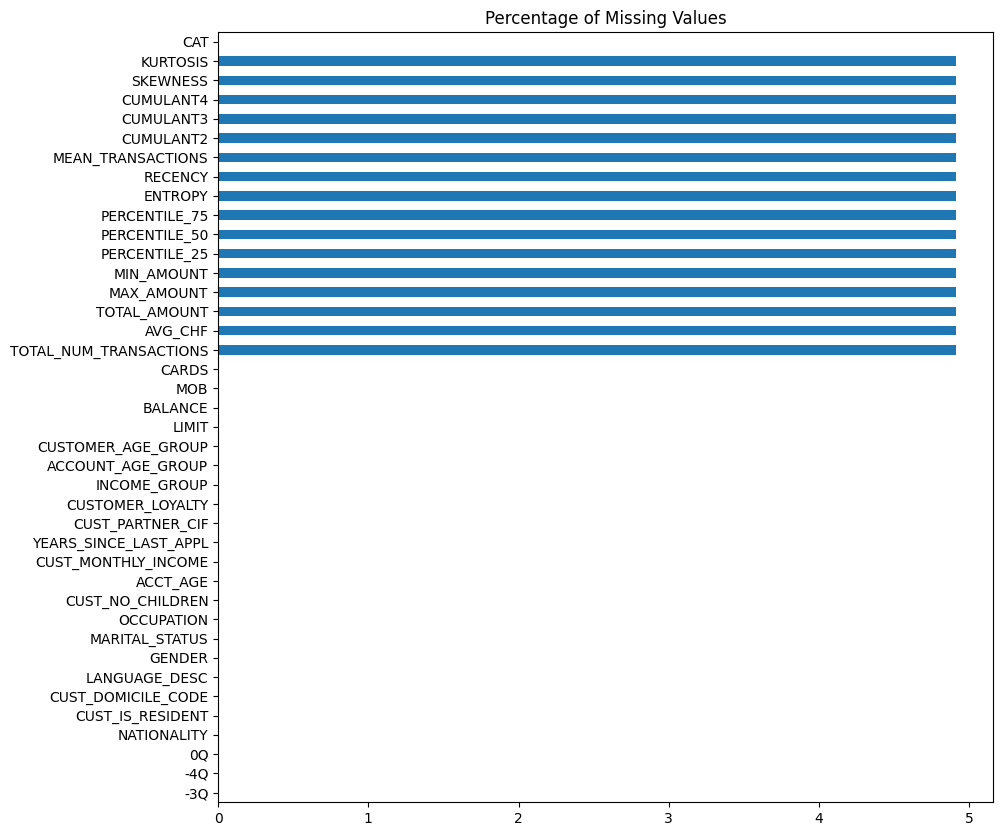

In [ ]:
(df.isna().sum()/len(df)*100).plot(kind = 'barh', figsize = (10,10))
plt.title('Percentage of Missing Values')
plt.show()

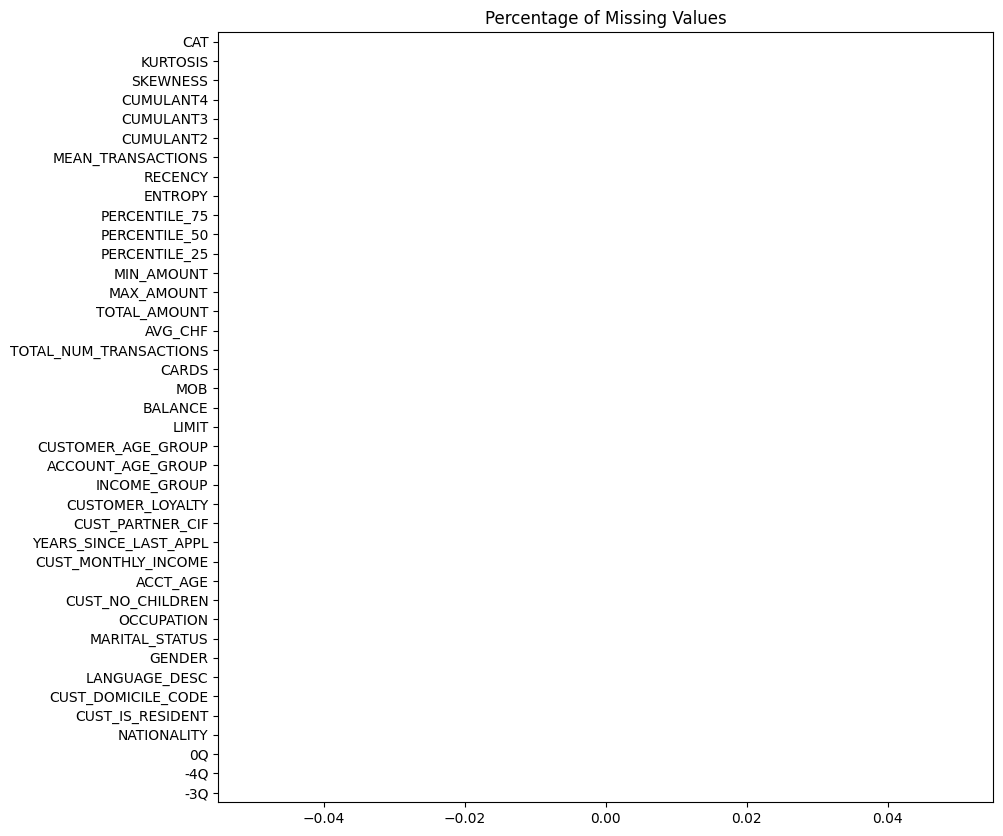

In [ ]:
df.fillna(0, inplace=True)

(df.isna().sum()/len(df)*100).plot(kind = 'barh', figsize = (10,10))
plt.title('Percentage of Missing Values')
plt.show()

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
# skip the label columns
categorical_cols = categorical_cols.drop(['CAT'])
categorical_cols = categorical_cols.tolist()
categorical_cols

['NATIONALITY',
 'CUST_IS_RESIDENT',
 'CUST_DOMICILE_CODE',
 'LANGUAGE_DESC',
 'GENDER',
 'MARITAL_STATUS',
 'OCCUPATION',
 'CUST_NO_CHILDREN',
 'CUST_PARTNER_CIF',
 'INCOME_GROUP',
 'ACCOUNT_AGE_GROUP',
 'CUSTOMER_AGE_GROUP']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# One-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_cols = encoder.fit_transform(df[categorical_cols])
encoded_cols = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
encoded_cols.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,NATIONALITY_Austria,NATIONALITY_France,NATIONALITY_Germany,NATIONALITY_Italy,NATIONALITY_Other,NATIONALITY_Portugal,NATIONALITY_Spain,NATIONALITY_Switzerland,NATIONALITY_Unknown,CUST_IS_RESIDENT_Non-Resident,CUST_IS_RESIDENT_Resident,CUST_IS_RESIDENT_Unknown,CUST_DOMICILE_CODE_AT,CUST_DOMICILE_CODE_CH,CUST_DOMICILE_CODE_DE,CUST_DOMICILE_CODE_ES,CUST_DOMICILE_CODE_FL,CUST_DOMICILE_CODE_FR,CUST_DOMICILE_CODE_GB,CUST_DOMICILE_CODE_IT,CUST_DOMICILE_CODE_MX,CUST_DOMICILE_CODE_PT,CUST_DOMICILE_CODE_TR,CUST_DOMICILE_CODE_Unknown,LANGUAGE_DESC_French,LANGUAGE_DESC_German,LANGUAGE_DESC_Italian,LANGUAGE_DESC_Unknown,GENDER_FEMALE,GENDER_MALE,GENDER_Unknown,MARITAL_STATUS_Divorced,MARITAL_STATUS_Married,MARITAL_STATUS_Separated,MARITAL_STATUS_Single,MARITAL_STATUS_Unknown,MARITAL_STATUS_Widow,OCCUPATION_Academic,OCCUPATION_Entertainment/Artist,OCCUPATION_General Self-employed,OCCUPATION_Independent Farmer,OCCUPATION_Labourer,OCCUPATION_Manager,OCCUPATION_Salaried Employee,OCCUPATION_Self-employed Craftsmen,OCCUPATION_Student/Retired,OCCUPATION_Unknown,CUST_NO_CHILDREN_Many,CUST_NO_CHILDREN_One,CUST_NO_CHILDREN_Two,CUST_NO_CHILDREN_Unknown,CUST_PARTNER_CIF_PCH,CUST_PARTNER_CIF_SCH,CUST_PARTNER_CIF_Unknown,INCOME_GROUP_High,INCOME_GROUP_Low,INCOME_GROUP_Medium,INCOME_GROUP_Unknown,ACCOUNT_AGE_GROUP_Established,ACCOUNT_AGE_GROUP_Long-term,ACCOUNT_AGE_GROUP_New,ACCOUNT_AGE_GROUP_Unknown,CUSTOMER_AGE_GROUP_Adult,CUSTOMER_AGE_GROUP_Senior,CUSTOMER_AGE_GROUP_Unknown,CUSTOMER_AGE_GROUP_Youth
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Dropping original categorical columns and adding encoded ones
dffdrop = df.drop(categorical_cols, axis=1)
df = pd.concat([dffdrop, encoded_cols], axis=1)
df

,-3Q,-4Q,0Q,ACCT_AGE,CUST_MONTHLY_INCOME,YEARS_SINCE_LAST_APPL,CUSTOMER_LOYALTY,LIMIT,BALANCE,MOB,CARDS,TOTAL_NUM_TRANSACTIONS,AVG_CHF,TOTAL_AMOUNT,MAX_AMOUNT,MIN_AMOUNT,PERCENTILE_25,PERCENTILE_50,PERCENTILE_75,ENTROPY,RECENCY,MEAN_TRANSACTIONS,CUMULANT2,CUMULANT3,CUMULANT4,SKEWNESS,KURTOSIS,CAT,NATIONALITY_Austria,NATIONALITY_France,NATIONALITY_Germany,NATIONALITY_Italy,NATIONALITY_Other,NATIONALITY_Portugal,NATIONALITY_Spain,NATIONALITY_Switzerland,NATIONALITY_Unknown,CUST_IS_RESIDENT_Non-Resident,CUST_IS_RESIDENT_Resident,CUST_IS_RESIDENT_Unknown,CUST_DOMICILE_CODE_AT,CUST_DOMICILE_CODE_CH,CUST_DOMICILE_CODE_DE,CUST_DOMICILE_CODE_ES,CUST_DOMICILE_CODE_FL,CUST_DOMICILE_CODE_FR,CUST_DOMICILE_CODE_GB,CUST_DOMICILE_CODE_IT,CUST_DOMICILE_CODE_MX,CUST_DOMICILE_CODE_PT,CUST_DOMICILE_CODE_TR,CUST_DOMICILE_CODE_Unknown,LANGUAGE_DESC_French,LANGUAGE_DESC_German,LANGUAGE_DESC_Italian,LANGUAGE_DESC_Unknown,GENDER_FEMALE,GENDER_MALE,GENDER_Unknown,MARITAL_STATUS_Divorced,MARITAL_STATUS_Married,MARITAL_STATUS_Separated,MARITAL_STATUS_Single,MARITAL_STATUS_Unknown,MARITAL_STATUS_Widow,OCCUPATION_Academic,OCCUPATION_Entertainment/Artist,OCCUPATION_General Self-employed,OCCUPATION_Independent Farmer,OCCUPATION_Labourer,OCCUPATION_Manager,OCCUPATION_Salaried Employee,OCCUPATION_Self-employed Craftsmen,OCCUPATION_Student/Retired,OCCUPATION_Unknown,CUST_NO_CHILDREN_Many,CUST_NO_CHILDREN_One,CUST_NO_CHILDREN_Two,CUST_NO_CHILDREN_Unknown,CUST_PARTNER_CIF_PCH,CUST_PARTNER_CIF_SCH,CUST_PARTNER_CIF_Unknown,INCOME_GROUP_High,INCOME_GROUP_Low,INCOME_GROUP_Medium,INCOME_GROUP_Unknown,ACCOUNT_AGE_GROUP_Established,ACCOUNT_AGE_GROUP_Long-term,ACCOUNT_AGE_GROUP_New,ACCOUNT_AGE_GROUP_Unknown,CUSTOMER_AGE_GROUP_Adult,CUSTOMER_AGE_GROUP_Senior,CUSTOMER_AGE_GROUP_Unknown,CUSTOMER_AGE_GROUP_Youth
0,0.00,1283.10,1100.62,12.0,6503.17,12.0,18.0,6000.0,-19.79,135,1,1.0,1100.62,1100.62,1100.62,1100.62,1100.62,1100.62,1100.62,0.00,6.0,0.08,0.00,0.00,0.000000e+00,0.00,-3.00,NEGATIVE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,979.40,1809.10,737.00,12.0,5165.00,12.0,12.0,16000.0,12909.91,135,1,2.0,368.50,737.00,437.00,300.00,334.25,368.50,402.75,1.00,8.0,0.15,4692.25,0.00,2.201721e+07,0.00,-2.75,TRUE POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,358.85,1716.50,404.11,12.0,3031.00,12.0,12.0,5000.0,3787.31,135,1,15.0,26.94,404.11,77.00,-2.81,6.41,20.65,27.90,3.70,8.0,1.15,688.79,18046.47,1.258844e+06,0.90,-0.69,FALSE POSITIVE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2046.20,1976.74,1598.35,12.0,3820.00,13.0,12.0,3000.0,1848.06,135,1,46.0,34.75,1598.35,401.70,0.40,4.98,9.18,20.69,5.43,2.0,3.54,6685.56,2147714.17,7.897477e+08,3.80,13.91,NEGATIVE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3112.37,650.76,648.07,12.0,6176.75,12.0,14.0,8000.0,4629.63,135,1,48.0,13.93,668.82,980.00,-580.00,1.20,8.90,27.26,4.95,6.0,3.69,36263.97,12660279.88,2.234689e+10,1.78,13.29,NEGATIVE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1

# Features and Labels

In [ ]:
df_model = df.copy()

labels = df_model['CAT'].map({'TRUE POSITIVE': 1, 'FALSE POSITIVE': 0, 'NEGATIVE' : 0})

features = df_model.drop(columns=['CAT']).iloc[:, np.r_[0:27]]
# features = df_model.drop(columns=['CAT']).iloc[:, np.r_[0:27,51:len(df_model.columns)-1]]

print(features.columns)

Index(['-3Q', '-4Q', '0Q', 'ACCT_AGE', 'CUST_MONTHLY_INCOME',
       'YEARS_SINCE_LAST_APPL', 'CUSTOMER_LOYALTY', 'LIMIT', 'BALANCE', 'MOB',
       'CARDS', 'TOTAL_NUM_TRANSACTIONS', 'AVG_CHF', 'TOTAL_AMOUNT',
       'MAX_AMOUNT', 'MIN_AMOUNT', 'PERCENTILE_25', 'PERCENTILE_50',
       'PERCENTILE_75', 'ENTROPY', 'RECENCY', 'MEAN_TRANSACTIONS', 'CUMULANT2',
       'CUMULANT3', 'CUMULANT4', 'SKEWNESS', 'KURTOSIS'],
      dtype='object')


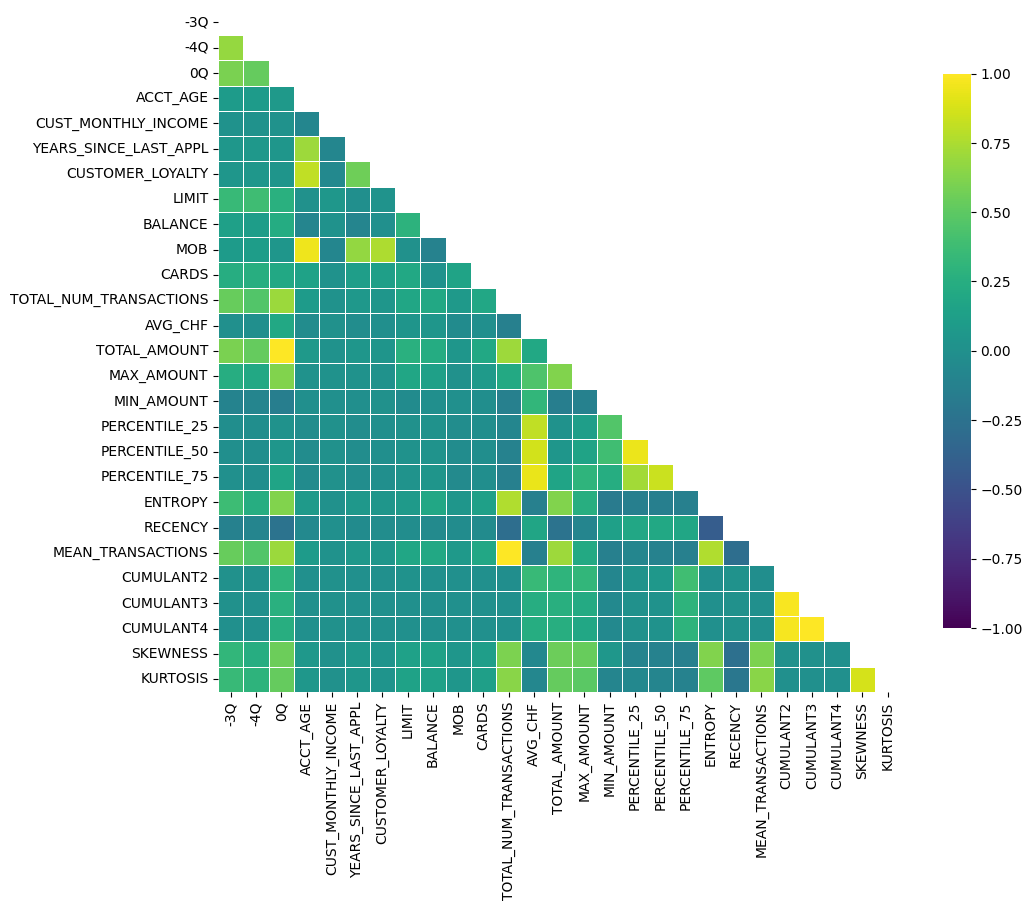

In [ ]:
# Compute the correlation matrix
corr = features.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=1., vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.show()

In [ ]:
labels.value_counts()

,count
CAT,
0,71176
1,28824


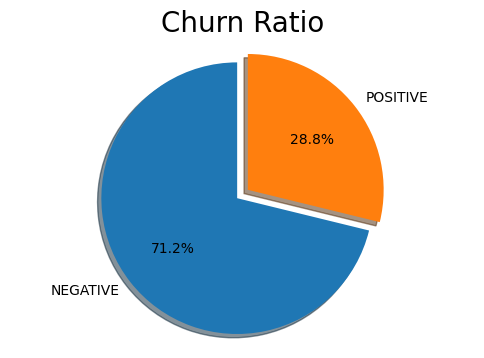

In [ ]:
tags = 'NEGATIVE', 'POSITIVE'
sizes = [labels[labels==0].count(), labels[labels==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.pie(sizes, explode=explode, labels=tags, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Churn Ratio", size = 20)
plt.show()

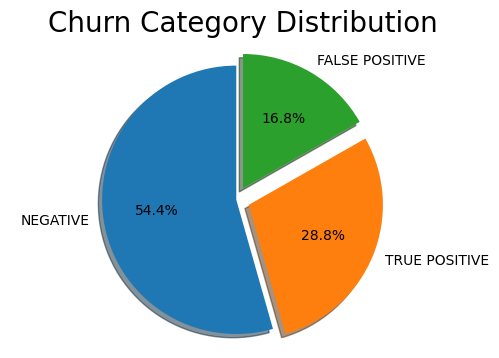

In [ ]:
tags = ['NEGATIVE', 'TRUE POSITIVE', 'FALSE POSITIVE']
sizes = [df['CAT'][df['CAT'] == 'NEGATIVE'].count(),
         df['CAT'][df['CAT'] == 'TRUE POSITIVE'].count(),
         df['CAT'][df['CAT'] == 'FALSE POSITIVE'].count()]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.pie(sizes, explode=explode, labels=tags, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Churn Category Distribution", size=20)
plt.show()

# Train data split and scale

In [ ]:
from sklearn.model_selection import train_test_split

Sample division into train, validation, and test datasets. There is no predefined rule; it largely depends on the total dataset size. Typically, it’s 60:20:20, but with large datasets, it can go up to 98:1:1.

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print('Training data shape: ',features_train.shape)
print('Training targets shape: ',labels_train.shape)
print('Test data shape: ',features_test.shape)
print('Test targets shape: ',labels_test.shape)

Training data shape:  (80000, 27)
Training targets shape:  (80000,)
Test data shape:  (20000, 27)
Test targets shape:  (20000,)


# ML Pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.pipeline import Pipeline

# Fit the models
Pipeline(steps=[('s', StandardScaler()), ('nb', GaussianNB())])
Pipeline(steps=[('s', StandardScaler()), ('dt', DecisionTreeClassifier())])
Pipeline(steps=[('s', StandardScaler()), ('lb', LGBMClassifier())])
[LightGBM] [Info] Number of positive: 22932, number of negative: 57068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5474
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286650 -> initscore=-0.911710
[LightGBM] [Info] Start training from score -0.911710
# Predict and evaluate
              precision    recall  f1-score   support

           0       0.93      0.24      0.38     14225
           1       0.34      0.96      0.50      5775

    accuracy                           0.45     20000
   macro avg       0.63      0.60      0

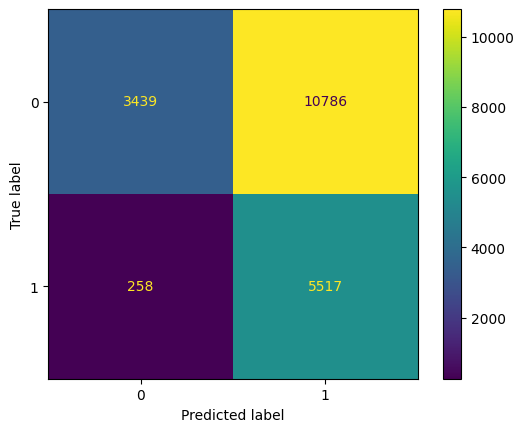

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     14225
           1       0.74      0.73      0.73      5775

    accuracy                           0.85     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.85      0.85      0.85     20000

Model: dt, Accuracy: 0.8469
Recall: [0.89427065 0.73021645]
Precision: [0.89088872 0.7371089 ]
Confusion Matrix:
 [[12721  1504]
 [ 1558  4217]]


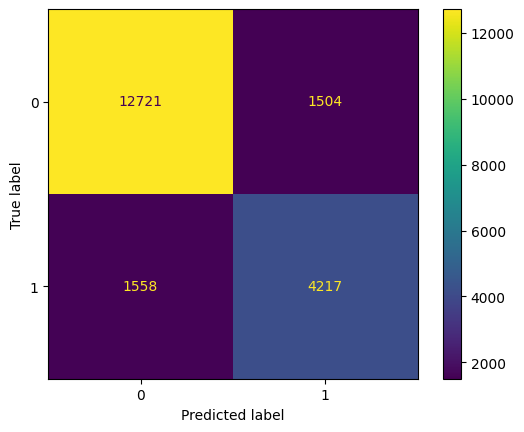

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     14225
           1       0.81      0.80      0.81      5775

    accuracy                           0.89     20000
   macro avg       0.87      0.86      0.87     20000
weighted avg       0.89      0.89      0.89     20000

Model: lb, Accuracy: 0.88965
Recall: [0.92499121 0.8025974 ]
Precision: [0.92026857 0.81287268]
Confusion Matrix:
 [[13158  1067]
 [ 1140  4635]]


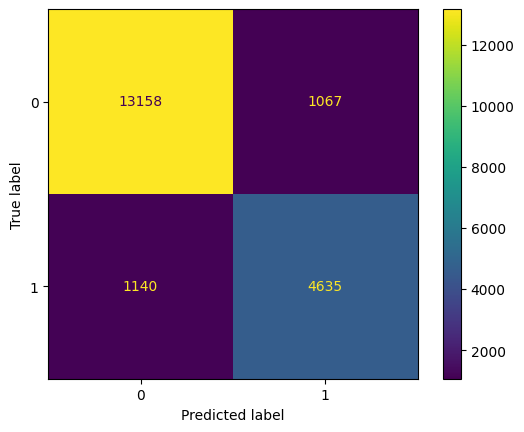

In [ ]:
# Define the pipelines
pipelines = {
    'nb': Pipeline([('s', StandardScaler()),
                    ('nb', GaussianNB())]),
    'dt': Pipeline([('s', StandardScaler()),
                    ('dt', DecisionTreeClassifier())]),
    # 'rf': Pipeline([('s', StandardScaler()),
    #                 ('rf', RandomForestClassifier())]),
    'lb': Pipeline([('s', StandardScaler()),
                    ('lb', LGBMClassifier())])
}


print('# Fit the models')
for model in pipelines.values():
    print(model)
    model.fit(features_train, labels_train)

print('# Predict and evaluate')
for name, model in pipelines.items():
    y_pred = model.predict(features_test)

    print(classification_report(labels_test, y_pred))

    accuracy = accuracy_score(labels_test, y_pred)

    print(f"Model: {name}, Accuracy: {accuracy}")

    print('Recall:', recall_score(labels_test, y_pred, average=None))

    print('Precision:', precision_score(labels_test, y_pred, average=None))

    cm = confusion_matrix(labels_test, y_pred)
    print('Confusion Matrix:\n', cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='')
    plt.show()
    # cm = confusion_matrix(labels_test, y_pred,normalize = 'pred')
    # ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='.0%')
    # plt.show()
    # cm = confusion_matrix(labels_test, y_pred,normalize = 'true')
    # ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='.0%')
    # plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

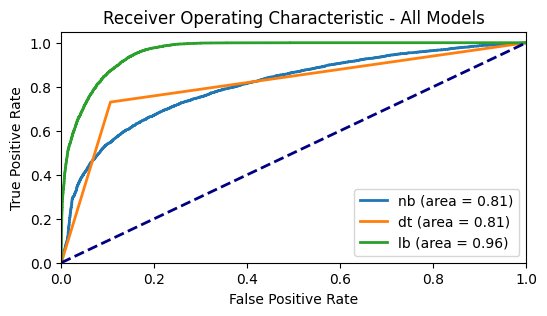

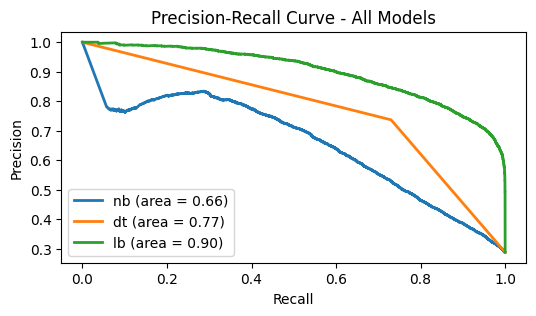

In [ ]:
# Plot combined ROC curves
plt.figure(figsize=(6, 3))
for name, model in pipelines.items():
    # Calculate ROC-AUC and plot ROC curve
    if hasattr(model.named_steps[model.steps[-1][0]], "predict_proba"):
        y_prob = model.predict_proba(features_test)[:, 1]
        fpr, tpr, _ = roc_curve(labels_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - All Models')
plt.legend(loc="lower right")
plt.show()

# Plot combined precision-recall curves
plt.figure(figsize=(6, 3))
for name, model in pipelines.items():
    if hasattr(model.named_steps[model.steps[-1][0]], "predict_proba"):
        y_prob = model.predict_proba(features_test)[:, 1]
        precision, recall, _ = precision_recall_curve(labels_test, y_prob)
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, lw=2, label=f'{name} (area = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - All Models')
plt.legend(loc="lower left")
plt.show()

# PyTorch ANN

In [ ]:
# pytorch
import torch
print(torch.__version__)

2.4.0+cu121


Using the GPU. If a GPU is available, it can be used to accelerate operations. This requires moving tensors to the GPU when performing calculations. It is advisable to check if the GPU is available and, if so, set an appropriate variable for subsequent use.

In [ ]:
# let's check if GPU is available and which type
if torch.cuda.is_available():
  print('Available GPUs number: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# if GPU is avialable let's set device='cuda', else 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Available GPUs number:  1
Tesla T4
Computation device: cuda



## Data Preprocessing and Conversion to PyTorch Tensors

This code cell performs several key preprocessing steps on the dataset:

1. **Standardization**: A `StandardScaler` object is created to standardize the features by removing the mean and scaling to unit variance. The scaler is fitted on the training data and then used to transform both the training and test datasets.
2. **Conversion to PyTorch Tensors**: The standardized features and labels from the pandas dataframes are converted into PyTorch tensors, which are required for training a neural network using PyTorch.

These steps ensure that the data is properly scaled and in the correct format for model training and evaluation.


In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit on your training data and transform both train and test data
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

# Convert the pandas dataframes into PyTorch tensors
train_data = torch.tensor(features_train, dtype=torch.float)
train_labels = torch.tensor(labels_train.to_numpy(), dtype=torch.long)

test_data = torch.tensor(features_test, dtype=torch.float)
test_labels = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

NOTE: Normalization of input features: Normalizing the input allows for the use of larger learning rates (faster training) and stabilizes the training process.

# Neural network model

## Shallow MLP

Architecture: Shallow MLP with dense layers (Linear in PyTorch): With a single hidden layer using ReLU activations, and 2 output neurons with softmax activation predicting the probability that the customer churned or not:

*   input layer: #features neurons
*   hidden layer: 1024 neurons, ReLU activation
*   output layer: 2 neurons, softmax activation

In [ ]:
inputneurons = features.shape[1]
inputneurons

27

In [ ]:
# define the 1st layer neurons
layer1neurons = 512

In [ ]:
from torch.utils.data import Dataset

# define the class CustomDataset that inherits from PyTorch’s Dataset class
class CustomDataset(Dataset):
    # constructor method that initializes the dataset object
    def __init__(self, features, labels):
        # converts the features input into a PyTorch tensor of type float
        self.data = torch.tensor(features, dtype=torch.float)
        # converts the labels input into a PyTorch tensor of type long
        self.targets = torch.tensor(labels.to_numpy(), dtype=torch.long)

    def __len__(self):
        # returns the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # retrieves the feature and target at the specified index idx
        return self.data[idx], self.targets[idx]

# Create your datasets:
# train_data and test_data are instances of the CustomDataset class,
# created using training and testing features and labels
train_data = CustomDataset(features_train, labels_train)
test_data = CustomDataset(features_test, labels_test)

This custom dataset can now be used with PyTorch’s data loaders to efficiently load data during model training and evaluation

In [ ]:
print('Training data shape: ',train_data.data.shape)
print('Training targets shape: ',train_data.targets.shape)
print('Test data shape: ',test_data.data.shape)
print('Test targets shape: ',test_data.targets.shape)

Training data shape:  torch.Size([80000, 27])
Training targets shape:  torch.Size([80000])
Test data shape:  torch.Size([20000, 27])
Test targets shape:  torch.Size([20000])


In [ ]:
# first customer features and label of the training sample
customer = (train_data.data)[0]
label = (train_data.targets)[0]

print(type(customer)) # tensor torch
print(type(label)) # tensor torch

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
print('shape customer: ', customer.shape)
print('shape customer: ', customer.numpy().shape)

shape customer:  torch.Size([27])
shape customer:  (27,)


In [ ]:
print(customer)
print(label)

tensor([ 1.1220, -0.7520,  0.2960, -0.4223,  0.0530, -0.3128, -0.6627,  0.7083,
         0.1715, -0.5206, -0.7114,  0.0934, -0.0732,  0.2804,  0.0504,  0.1964,
        -0.0564,  0.0415, -0.0248,  0.6363, -0.2976,  0.0936, -0.0358, -0.0071,
        -0.0042,  0.8532,  0.5070])
tensor(0)


In [ ]:
print((train_data[0])[0])

tensor([ 1.1220, -0.7520,  0.2960, -0.4223,  0.0530, -0.3128, -0.6627,  0.7083,
         0.1715, -0.5206, -0.7114,  0.0934, -0.0732,  0.2804,  0.0504,  0.1964,
        -0.0564,  0.0415, -0.0248,  0.6363, -0.2976,  0.0936, -0.0358, -0.0071,
        -0.0042,  0.8532,  0.5070])


In [ ]:
from torch import nn
import torch.nn.functional as F

# In PyTorch, a neural network is implemented by creating a Python class that inherits
# from PyTorch's nn.Module class and implements two basic methods:
# __init__: definition of the layers used
# forward: function that computes y = ANN(x)

In [ ]:
class ShallowMLP(nn.Module):
    def __init__(self, input_dim=inputneurons, output_dim=2, hidden_dim=layer1neurons):
        super(ShallowMLP, self).__init__()

        self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
        self.layer2 = nn.Linear(hidden_dim, output_dim) #output layer

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        # x = F.tanh(x)
#         x = F.sigmoid(x)
        out = self.layer2(x)
        return out

In [ ]:
# we can do the same for a deep ANN
class DeepMLP(nn.Module):
    def __init__(self, input_dim=inputneurons, output_dim=2, hidden_dim1=layer1neurons, hidden_dim2=layer1neurons):
        super(DeepMLP, self).__init__()

        self.layer1 = nn.Linear(input_dim, hidden_dim1)  # first hidden layer
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)  # second hidden layer
        self.layer3 = nn.Linear(hidden_dim2, output_dim)  # output layer

    def forward(self, x):
        x = F.relu(self.layer1(x))  # activation function for first hidden layer
        x = F.relu(self.layer2(x))  # activation function for second hidden layer
        out = self.layer3(x)  # no activation function for the output layer
        return out

In [ ]:
from torchsummary import summary

In [ ]:
# printout the model

model = ShallowMLP()
model = DeepMLP()
print(model)

if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,inputneurons))
else:
  summary(model, input_size=(1,inputneurons))

DeepMLP(
  (layer1): Linear(in_features=27, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]          14,336
            Linear-2               [-1, 1, 512]         262,656
            Linear-3                 [-1, 1, 2]           1,026
Total params: 278,018
Trainable params: 278,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.06
Estimated Total Size (MB): 1.07
----------------------------------------------------------------


## Training and Validation

In [ ]:
# Train-Validation:
# We split the dataset into two subsets to be used in training as
# the training set and validation set, respectively. The validation set is used to tune
# the network's hyperparameters and evaluate the model’s performance on unseen data.

tr_data, val_data = torch.utils.data.random_split(train_data, [train_data.targets.shape[0] - test_data.targets.shape[0], test_data.targets.shape[0]])

# Mini-Batches:
# When training a neural network using SGD (Stochastic Gradient Descent), especially with large datasets,
# it’s computationally efficient to divide the data into smaller chunks called mini-batches.
# This allows the model to update its parameters more frequently and can lead to faster convergence.
# This process is handled automatically in PyTorch through helper functions called Data Loaders.

batch = 100

# Data Loaders:
# In PyTorch, DataLoader is a utility that abstracts the complexity of managing mini-batches,
# reshuffling, and applying transformations. It provides an efficient way to iterate over the dataset.
# Data transformations (like normalization, augmentation, etc.) are often applied to the training data
# to improve the model’s performance and robustness.
# To ensure that the model generalizes well and does not overfit to the order of the training data,
# it’s common practice to reshuffle the data at the beginning of each epoch.
# We use three loader (train, val and test) (or we could use a dictionary to group them and read them at once)

from torch.utils.data import DataLoader

train_dl = DataLoader(tr_data,
                      batch_size=batch,
                      shuffle=True,
                      num_workers=0,
                      drop_last=True)

vali_dl = DataLoader(val_data,
                      batch_size=batch,
                      shuffle=True,
                      num_workers=0,
                      drop_last=True)

test_dl = DataLoader(test_data,
                     batch_size=batch,
                     shuffle=True,
                     num_workers=0)

In [ ]:
# next(iter(train_dl)) retrieves the first batch of data from the train_dl data loader.
# Let's test a batch on the 'untrained' model to check that everything works well

feat, label = next(iter(train_dl))
feat, label

(tensor([[-0.9989, -0.7602, -0.7846,  ..., -0.0042, -0.6724, -0.6006],
         [ 0.4682,  0.6079,  1.0544,  ..., -0.0042, -0.1083,  0.0906],
         [ 1.1229, -0.7579, -0.7282,  ..., -0.0042, -0.4288, -0.5083],
         ...,
         [-0.9886, -0.6275, -0.0777,  ..., -0.0041, -0.1724, -0.1035],
         [-0.8607, -0.7780, -0.7746,  ..., -0.0042, -0.9629, -0.6330],
         [-0.1526, -0.3597, -0.8632,  ..., -0.0042, -1.6509, -0.4393]]),
 tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 1]))

In [ ]:
feat.shape, label.shape

(torch.Size([100, 27]), torch.Size([100]))

In [ ]:
# Move the feat (features) and label (labels) tensors to the specified device (e.g., CPU or GPU)
# Moving tensors to the appropriate device ensures that computations are performed on the GPU if available,
# which can significantly speed up training and inference.
feat=feat.to(device)
label=label.to(device)

# Pass the features (feat) through the model to get the output (out)
out = model(feat)

# The shape of the prediction is a batch*classes_number tensor
print(out.shape)

# First element of the output tensor, i.e. the predictions for the first sample in the batch.
# The values are the raw output (logits) from the model for the first sample in the batch
print(out[0])

torch.Size([100, 2])
tensor([ 0.0918, -0.0008], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# The logits are not probabilities but can be converted to probabilities using a softmax function
# This applies the softmax function along the second dimension (the class dimension) of the output tensor, converting the logits to probabilities
probs = F.softmax(out, dim=1)
print(probs[0])

tensor([0.5231, 0.4769], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# To complete the model, we need to define the loss function, any metrics to monitor the
# training of the network, and finally the optimizer

loss_func = nn.CrossEntropyLoss() #cross entropy loss
# loss_func = nn.NLLLoss() #alternatively with log_softmax (same result)


def accuracy(yhat, y):
    #predictions == neurons with the highest probability
    #computes the maximum value along dimension 1 (the class dimension in classification) for each sample in yhat
    preds = torch.max(yhat,1)[1]

    #count the number of True values, giving the total number of correct predictions in the batch
    batch_acc = (preds == y).sum()
    return batch_acc


# !pip install torchmetrics

# from torchmetrics.classification import MulticlassPrecision, MulticlassRecall

# # Initialize metrics with the appropriate task
# precision = MulticlassPrecision(num_classes=2)
# recall = MulticlassRecall(num_classes=2)


def precision(yhat, y):
    preds = torch.max(yhat, 1)[1]
    tp = torch.sum((preds == 1) & (y == 1)).float()
    fp = torch.sum((preds == 1) & (y == 0)).float()

    prec = tp / (tp + fp) if tp + fp > 0 else torch.tensor(0.0).to(y.device)
    return prec

def recall(yhat, y):
    preds = torch.max(yhat, 1)[1]
    tp = torch.sum((preds == 1) & (y == 1)).float()
    fn = torch.sum((preds == 0) & (y == 1)).float()

    rec = tp / (tp + fn) if tp + fn > 0 else torch.tensor(0.0).to(y.device)
    return rec

In [ ]:
# optimizer: for example, we use stochastic gradient descent with momentum,
# that helps accelerate SGD in the relevant direction and dampens oscillations.
# Momentum helps overcome small local minima. Without it, the optimizer might
# get stuck more easily.
# The weights and biases of the neural network that need to be updated
# during training are defined by model.parameters() and the learning rate lr
# which controls how much to change the model parameters in response
# to the estimated error each time the model weights are updated

from torch import optim
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
# if available we move the model on the GPU
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [ ]:
import time

# In pytorch we need to write the training loop, i.e. the loop on the epochs of training.
# In each epoch we read all events of the dataset and update the nn weigths after each mini-batch
# number of epochs
epochs = 100

# lists to save the value of the loss and the metrics at each epoch to be able to plot them as a function
# of the epoch at the end of training
hist_time = []
hist_loss = []
hist_accuracy = []
hist_precision = []
hist_recall = []
hist_vloss = []
hist_vaccuracy = []
hist_vprecision = []
hist_vrecall = []

# loop over epochs
for epoch in range(epochs):
    print(f"\nEpoch: {epoch + 1}")
    t0 = time.time()
    # training step (where we update the weights of the neural network)
    model.train()
    train_loss = 0
    train_accuracy = 0
    train_precision = 0
    train_recall = 0
    counter = 0
    for xb, yb in train_dl:
        counter += 1
        xb = xb.to(device)  # copy the mini-batch of data to the CPU/GPU
        yb = yb.to(device)  # copy the mini-batch of labels to the CPU/GPU
        pred = model(xb)  # model prediction
        # calculate loss and metrics
        loss = loss_func(pred, yb)
        batch_accuracy = accuracy(pred, yb)
        batch_precision = precision(pred, yb)
        batch_recall = recall(pred, yb)
        # update total loss and metrics
        train_loss += loss.item()
        train_accuracy += batch_accuracy.item()
        train_precision += batch_precision.item()
        train_recall += batch_recall.item()
        # backpropagation
        opt.zero_grad()  # reset gradients before performing backpropagation
        loss.backward()  # calculate the gradients of the loss
        opt.step()  # update the weights
    train_loss /= counter
    train_accuracy /= (counter * batch)
    train_precision /= counter
    train_recall /= counter
    hist_loss.append(train_loss)
    hist_accuracy.append(train_accuracy)
    hist_precision.append(train_precision)
    hist_recall.append(train_recall)

    # validation step (weights are not updated)
    model.eval() # ensures that the model behaves consistently during evaluation, giving the same output for the same input
    vali_loss = 0
    vali_accuracy = 0
    vali_precision = 0
    vali_recall = 0
    counter = 0
    with torch.no_grad():  # prevent weights from being updated
        for xb, yb in vali_dl:
            counter += 1
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)  # model prediction
            # calculate loss and metrics
            vloss = loss_func(pred, yb)
            batch_accuracy = accuracy(pred, yb)
            batch_precision = precision(pred, yb)
            batch_recall = recall(pred, yb)
            vali_loss += vloss.item()
            vali_accuracy += batch_accuracy.item()
            vali_precision += batch_precision.item()
            vali_recall += batch_recall.item()
    vali_loss /= counter
    vali_accuracy /= (counter * batch)
    vali_precision /= counter
    vali_recall /= counter
    hist_vloss.append(vali_loss)
    hist_vaccuracy.append(vali_accuracy)
    hist_vprecision.append(vali_precision)
    hist_vrecall.append(vali_recall)

    elapsed_time = time.time() - t0
    hist_time.append(elapsed_time)
    print(f"Time: {elapsed_time:.4f}s")
    print(f"Train -> Loss: {train_loss:.6f}, Accuracy: {train_accuracy:.6f}, Precision: {train_precision:.6f}, Recall: {train_recall:.6f}")
    print(f"Val   -> Loss: {vali_loss:.6f}, Accuracy: {vali_accuracy:.6f}, Precision: {vali_precision:.6f}, Recall: {vali_recall:.6f}")


Epoch: 1
Time: 1.9652s
Train -> Loss: 0.434689, Accuracy: 0.802667, Precision: 0.696847, Recall: 0.419116
Val   -> Loss: 0.343316, Accuracy: 0.845400, Precision: 0.799067, Recall: 0.602305

Epoch: 2
Time: 1.8975s
Train -> Loss: 0.329723, Accuracy: 0.848100, Precision: 0.803388, Recall: 0.626123
Val   -> Loss: 0.312409, Accuracy: 0.856550, Precision: 0.804180, Recall: 0.649267

Epoch: 3
Time: 2.3024s
Train -> Loss: 0.311955, Accuracy: 0.855383, Precision: 0.801670, Recall: 0.663142
Val   -> Loss: 0.302659, Accuracy: 0.859800, Precision: 0.795754, Recall: 0.676951

Epoch: 4
Time: 2.2835s
Train -> Loss: 0.303223, Accuracy: 0.858500, Precision: 0.795225, Recall: 0.685007
Val   -> Loss: 0.296150, Accuracy: 0.863550, Precision: 0.789950, Recall: 0.704664

Epoch: 5
Time: 1.8776s
Train -> Loss: 0.296582, Accuracy: 0.860317, Precision: 0.791898, Recall: 0.698949
Val   -> Loss: 0.290693, Accuracy: 0.864350, Precision: 0.783437, Recall: 0.721122

Epoch: 6
Time: 1.8645s
Train -> Loss: 0.291222, A

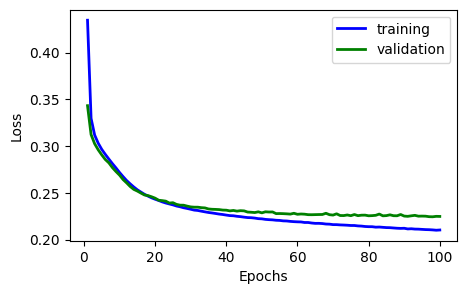

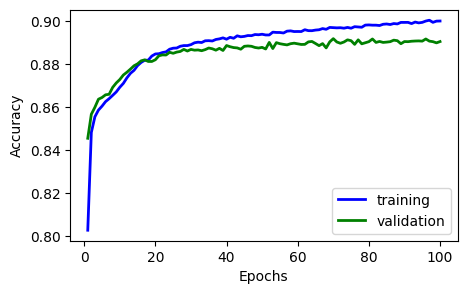

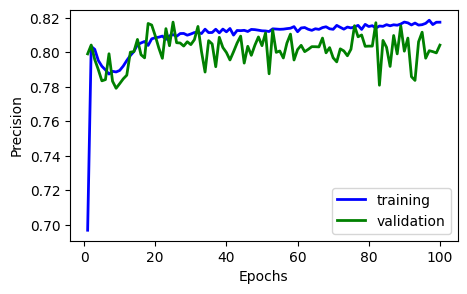

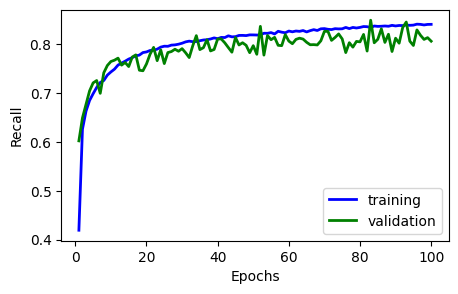

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='blue', linestyle='-', label='training', lw=2)
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='green', linestyle='-', label='validation', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(range(1,len(hist_accuracy)+1),hist_accuracy, color='blue', linestyle='-', label='training', lw=2)
plt.plot(range(1,len(hist_vaccuracy)+1),hist_vaccuracy, color='green', linestyle='-', label='validation', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(range(1,len(hist_precision)+1),hist_precision, color='blue', linestyle='-', label='training', lw=2)
plt.plot(range(1,len(hist_vprecision)+1),hist_vprecision, color='green', linestyle='-', label='validation', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(range(1,len(hist_recall)+1),hist_recall, color='blue', linestyle='-', label='training', lw=2)
plt.plot(range(1,len(hist_vrecall)+1),hist_vrecall, color='green', linestyle='-', label='validation', lw=2)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

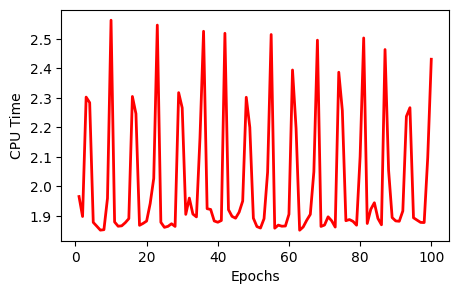

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1,len(hist_time)+1),hist_time, color='red', linestyle='-', label='training', lw=2)
plt.xlabel('Epochs')
plt.ylabel('CPU Time')
# plt.legend()
plt.show()

# Test the model

In [ ]:
# torch.save(model, 'torch_trained_eth.pt')
# model = torch.load('./torch_trained_eth.pt')
model

DeepMLP(
  (layer1): Linear(in_features=27, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=2, bias=True)
)

Test loss: 0.229911
Test accuracy: 0.886450
Test precision: 0.799078
Test recall: 0.812152
Test F1 score: 0.805562


<Figure size 1000x800 with 0 Axes>

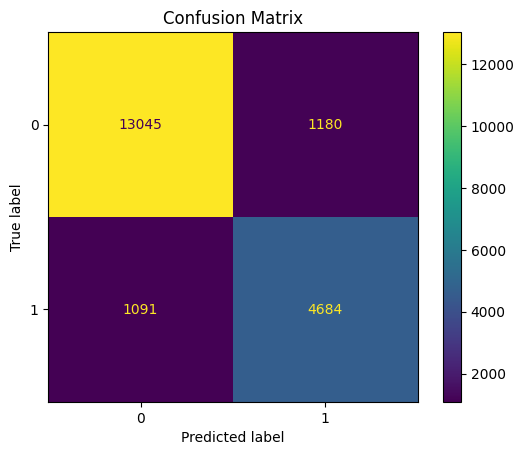

In [ ]:
# Some layers like dropout and batch normalization behave differently
# during training and inference.
# eval() ensures they behave correctly for inference
model.eval()

# for the inference it is not necessay to run on GPU
model.to(torch.device('cpu'))

# Initialize variables for metrics
test_loss = 0
test_accuracy = 0
test_precision = 0
test_recall = 0
counter = 0

# Initialize empty lists for true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():  # Disable gradient computation
    for xb, yb in test_dl:
        counter += 1
        xb = xb.to('cpu')
        yb = yb.to('cpu')
        pred = model(xb)

        # Calculate metrics
        test_loss += loss_func(pred, yb).item()
        test_accuracy += accuracy(pred, yb).item()
        test_precision += precision(pred, yb).item()
        test_recall += recall(pred, yb).item()

        # Convert predicted labels to numpy array
        pred_labels = torch.max(pred, 1)[1].numpy()
        true_labels.extend(yb.numpy())
        predicted_labels.extend(pred_labels)

# Calculate average metrics
test_loss /= counter
test_accuracy /= (counter * batch)
test_precision /= counter
test_recall /= counter

# Print results
print(f'Test loss: {test_loss:.6f}')
print(f'Test accuracy: {test_accuracy:.6f}')
print(f'Test precision: {test_precision:.6f}')
print(f'Test recall: {test_recall:.6f}')

# Compute F1 score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f'Test F1 score: {f1_score:.6f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(values_format='')
plt.title('Confusion Matrix')
plt.show()